# Masterclass Qiskit — 01 • Superposition & Parallélisme

**Objectif :** comprendre la superposition et l'idée de parallélisme **sans portes avancées** et **sans sphère de Bloch**.  
**Uniquement** : `H`, `X`, `CX`, mesures, histogrammes.

**Plan (≈35–45 min)**  
1. 1 qubit : `H` crée 50/50 ; `X` inverse.  
2. 2 qubits : superposition uniforme (`H` sur tous) et sélective (`H` sur un seul).  
3. Parallélisme (intuition Deutsch, mini-version) : distinguer **constante** vs **équilibrée** avec une seule passe.
4. Exercices courts et auto-vérifs.

## 0. Imports

In [7]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('qasm_simulator')

## 1. Un seul qubit : `H` et `X`

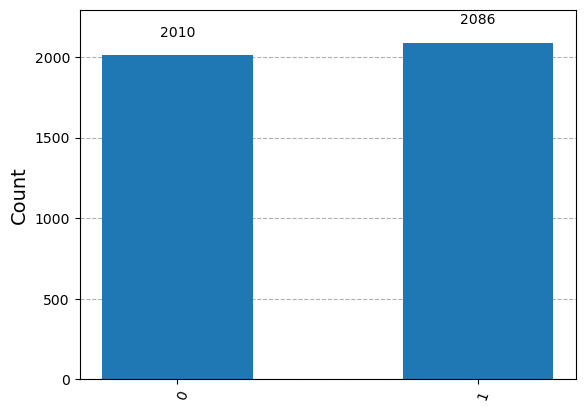

In [8]:
# H seul : |0> --H--> (|0>+|1>)/sqrt(2) -> 50/50 après mesure
qc = QuantumCircuit(1,1)
qc.h(0)
qc.measure(0,0)
plot_histogram(backend.run(transpile(qc, backend), shots=4096).result().get_counts())

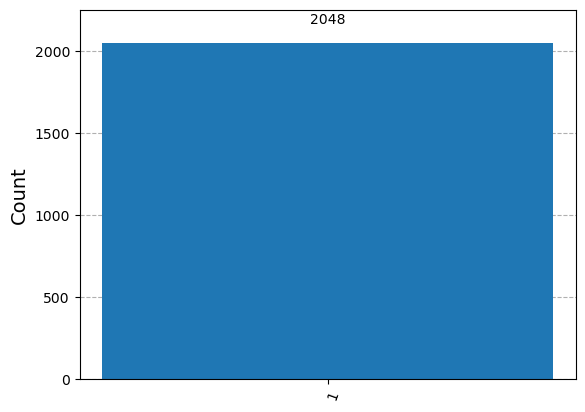

In [9]:
# X seul : |0> --X--> |1> -> toujours 1 après mesure
qc_x = QuantumCircuit(1,1)
qc_x.x(0)
qc_x.measure(0,0)
plot_histogram(backend.run(transpile(qc_x, backend), shots=2048).result().get_counts())

In [10]:
# Ordre des portes : H puis X vs X puis H (regarder la distribution)
qc_hx = QuantumCircuit(1,1); qc_hx.h(0); qc_hx.x(0); qc_hx.measure(0,0)
qc_xh = QuantumCircuit(1,1); qc_xh.x(0); qc_xh.h(0); qc_xh.measure(0,0)

counts_hx = backend.run(transpile(qc_hx, backend), shots=4096).result().get_counts()
counts_xh = backend.run(transpile(qc_xh, backend), shots=4096).result().get_counts()
counts_hx, counts_xh

({'1': 2073, '0': 2023}, {'1': 2094, '0': 2002})

**À retenir** : `H` crée une **superposition**. `X` inverse 0 ↔ 1. L'ordre des opérations **compte**.

## 2. Deux qubits : superposition simple

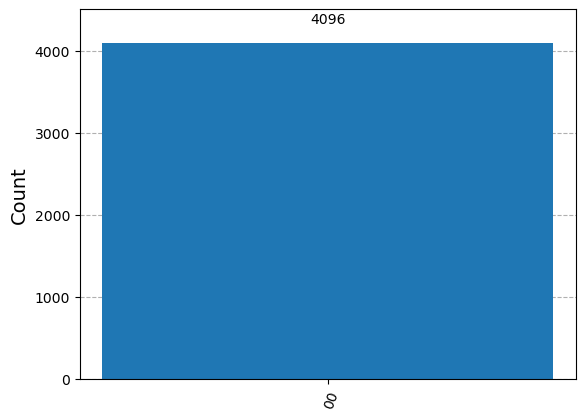

In [13]:
# Superposition uniforme sur 2 qubits : H sur chacun
qc2 = QuantumCircuit(2,2)
# Votre code
qc2.measure([0,1],[0,1])
plot_histogram(backend.run(transpile(qc2, backend), shots=4096).result().get_counts())

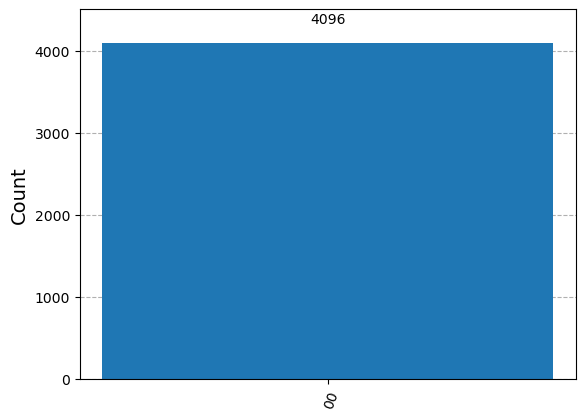

In [14]:
# Superposition sélective : H seulement sur le premier qubit
qc2_sel = QuantumCircuit(2,2)
# Votre code
qc2_sel.measure([0,1],[0,1])
plot_histogram(backend.run(transpile(qc2_sel, backend), shots=4096).result().get_counts())

**Lecture** : `H` sur tous les qubits crée `2^n` chemins simultanés. Appliquer ensuite des portes agit **sur tous les chemins** en même temps (linéarité).

## 3. Parallélisme (intuition Deutsch très simple)
**Problème** : on a une fonction binaire `f` sur 1 bit (donc 2 entrées possibles `0` ou `1`).  
On veut savoir si `f` est **constante** (renvoie toujours le même bit) ou **équilibrée** (sorties différentes selon l'entrée).  
**Idée** : préparer l'entrée en superposition, faire passer **toutes** les entrées d’un coup, puis lire un motif caractéristique.

### 3.1 Oracles (uniquement H/X/CX)
- **Constante 0** : ne rien faire sur la sortie (elle reste 0).  
- **Constante 1** : faire `X` sur la sortie.  
- **Équilibrée (identité)** : copier l'entrée vers la sortie avec `CX`.

In [15]:
def deutsch_constant0():
    # Entrée en |+>, sortie en |0>, puis on lit l'entrée après H final
    qc = QuantumCircuit(2,1)  # q0 = entrée, q1 = sortie (non mesurée ici)
    qc.h(0)       # superposition |+>
    # oracle f(x)=0 : rien à faire sur q1
    qc.h(0)       # H final sur l'entrée
    qc.measure(0,0)
    return qc

def deutsch_constant1():
    qc = QuantumCircuit(2,1)
    qc.h(0)
    qc.x(1)       # oracle f(x)=1 : X sur la sortie
    qc.h(0)
    qc.measure(0,0)
    return qc

def deutsch_balanced_identity():
    qc = QuantumCircuit(2,1)
    qc.h(0)       # superposition sur l'entrée
    qc.cx(0,1)    # f(x)=x : copie en sortie
    qc.h(0)       # lecture globale sur l'entrée
    qc.measure(0,0)
    return qc

qc_c0 = deutsch_constant0()
qc_c1 = deutsch_constant1()
qc_bal = deutsch_balanced_identity()

counts_c0 = backend.run(transpile(qc_c0, backend), shots=2048).result().get_counts()
counts_c1 = backend.run(transpile(qc_c1, backend), shots=2048).result().get_counts()
counts_bal = backend.run(transpile(qc_bal, backend), shots=2048).result().get_counts()
counts_c0, counts_c1, counts_bal

({'0': 2048}, {'0': 2048}, {'0': 1036, '1': 1012})

**Interprétation rapide** (version ultra simple) :  
- Pour les **constantes**, le motif de l'entrée après le `H` final est **0** dominant.  
- Pour l'**équilibrée** (identité), le motif de l'entrée après le `H` final n'est **pas** dominé par `0` (souvent `1`).  
> Cela **illustre** le gain : on a évalué `f` sur `0` et `1` **simultanément** grâce à la superposition.

## 4. Exercices (sans portes avancées)
1. **Trois qubits uniformes** : crée une superposition uniforme sur 3 qubits et vérifie que les 8 issues apparaissent.  
2. **Sélectif** : crée une superposition uniquement sur le qubit du milieu (q1) dans un circuit 3 qubits ; observe la distribution.  
3. **Défi Deutsch minimal** : remplace l'oracle identitaire par un oracle **négation** `f(x)=¬x` (utilise `X` autour d'un `CX`), et observe le motif obtenu.

In [ ]:
# Exo 1 — zone de réponse
qc_ex1 = QuantumCircuit(3,3)
# TODO: H sur tous
qc_ex1.measure([0,1,2],[0,1,2])
plot_histogram(backend.run(transpile(qc_ex1, backend), shots=4096).result().get_counts())

In [ ]:
# Exo 2 — zone de réponse
qc_ex2 = QuantumCircuit(3,3)
# TODO: H uniquement sur q1
qc_ex2.measure([0,1,2],[0,1,2])
plot_histogram(backend.run(transpile(qc_ex2, backend), shots=4096).result().get_counts())

In [ ]:
# Exo 3 — oracle f(x)=¬x (piste: X sur la cible avant/après CX)
def deutsch_balanced_not():
    qc = QuantumCircuit(2,1)
    qc.h(0)        # entrée en |+>
    qc.x(1); qc.cx(0,1); qc.x(1)  # oracle NOT: y <- y XOR (NOT x)
    qc.h(0)
    qc.measure(0,0)
    return qc

plot_histogram(backend.run(transpile(deutsch_balanced_not(), backend), shots=2048).result().get_counts())